### Imports
Uses the mabwiser library for contextual bandits

In [43]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy
import matplotlib.pyplot as plt

### Load data and split in train-test
The dataset contains the rewards of 300k pulls of a set of five arms. For each pull, the context vector is reported

In [44]:
with open('arm_actions_exercise.pickle', 'rb') as fin:
    df_pulls = pickle.load(fin)
features = ['f1', 'f2', 'f3', 'f4', 'f5']
arms = sorted(df_pulls['item_id'].unique().tolist())

We split the dataset in training and test. We will first train a contextual bandit on the training and apply the model on the test set, just to see which arms end up being pulled by the model during test. We will then transition to a more realistic evaluation using replay -- we will still train the model on part of the data, but the testing will be performed using replay.

In [45]:
# split training and test
n_train = 200000
n_test = 100000
df_pulls_train = df_pulls.head(n_train)
df_pulls_test = df_pulls.tail(n_test)
df_pulls_train.head(5)

,ts,item_id,reward,f1,f2,f3,f4,f5
0,0,1,0.9990,0.7855,0.2211,0.3751,0.4707,0.2969
119829,1,3,0.6048,0.3453,0.4848,0.8147,0.5744,0.4313
1,2,1,0.0010,0.8084,0.2534,0.3193,0.4519,0.2274
179785,3,5,0.6301,0.3529,0.3044,0.3921,0.4469,0.7656
119830,4,3,0.9990,0.3435,0.4457,0.9258,0.5537,0.4915


### Train-test split
Simple training and application of trained model to test set. This is useful to see how the mabwiser library works (very similar to any ML library in pyhton)

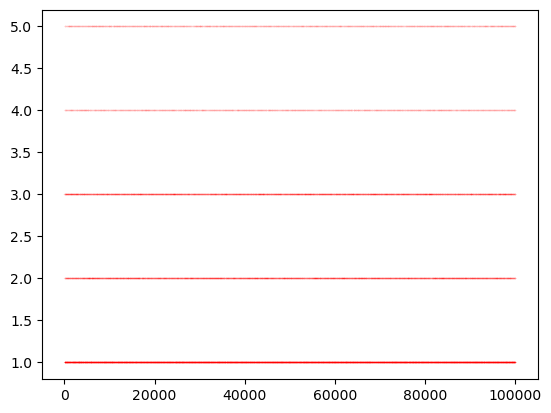

In [46]:
# Scale the training and test data
scaler = StandardScaler()

# Extract context vectors
context_train = scaler.fit_transform(df_pulls_train[features])
context_test = scaler.transform(df_pulls_test[features]) # note that here we don't fit again on test data

# Extract the list of pulled arms and their rewards in the training set
pulls_train = df_pulls_train['item_id'].values.tolist()
rewards_train = df_pulls_train['reward'].values.tolist()

# Instantiate a bandit with a LinUCB learning policy
linucb = MAB(arms=arms, learning_policy=LearningPolicy.LinUCB(alpha=1))
# The bandit is trained on the training data
linucb.fit(decisions=pulls_train, rewards=rewards_train, contexts=context_train)
# Predict arms from context in the test set
prediction = linucb.predict(context_test)
# stores the prediction in a dataframe for convenience
p = pd.DataFrame(prediction, columns=['arm']).reset_index()

# simple visualization of arms on the y-axis and time on the x-axis. Each dot is a pull
plt.scatter(p['index'], p['arm'], alpha=0.005, s=1, c='red')

### Replay evaluation
Now we would like to evaluate the badit on the test set, using replay. Modify the run_replay function we used for context-free bandits to adapt it to the contextual case.

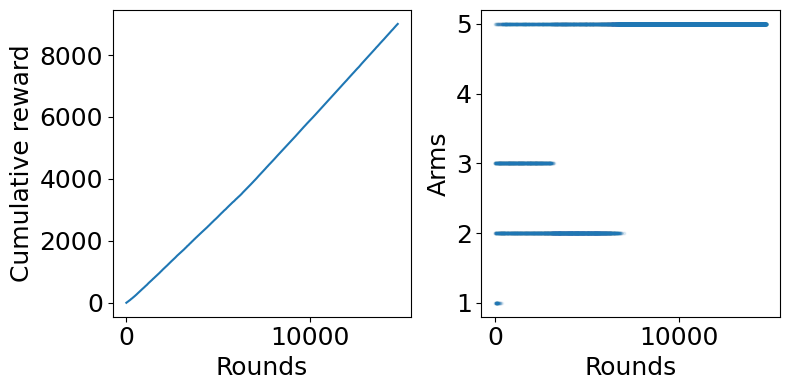

In [47]:
def visualize_simulation(cum_rewards, pull_history, savefile=None):
    """
    Utility function to draw a visual representation of the simulation
    @param cum_rewards: list of cumulative rewards in time
    @param pull_history: list of arm indices pulled over time
    """
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    ax1, ax2=axs
    ax1.plot(range(0,len(cum_rewards)), cum_rewards)
    ax1.set_ylabel('Cumulative reward', fontsize=18)
    ax1.set_xlabel('Rounds', fontsize=18)
    ax2.scatter(range(0,len(pull_history)), pull_history, s=3, alpha=0.05)
    ax2.set_ylabel('Arms', fontsize=18)
    ax2.set_xlabel('Rounds', fontsize=18)
    ax1.tick_params(labelsize=18)
    ax2.tick_params(labelsize=18)
    plt.tight_layout()
    if savefile:
        plt.savefig(savefile, dpi=400)
        
def run_replay(data, bandit: MAB, verbose=False):
    """
    Runs a Replay offline evaluation with the given data
    @param data: a list of (arm,reward,context) tuples
    @param bandit: an instance of bandit
    @param verbose: for a verbose representation of the replay
    """
    replay_num_matches = 0
    replay_tot_rewards = 0
    replay_cum_rewards = []
    pull_history = []
    for i, action in enumerate(data):
        actual_arm, reward, context = action

        # select an arm using the bandit strategy
        arm = bandit.predict([context])
        
        # if selected arm does not match the arm in the data, disregard
        if actual_arm == arm:
            # update the strategy of the contextual bandit based on the arm, reward, and context
            bandit.partial_fit([arm], [reward], [context])
            # update all variables (replay_num_matches, replay_tot_rewards, etc.)
            replay_num_matches += 1
            replay_tot_rewards += reward
            replay_cum_rewards.append(replay_tot_rewards)
            pull_history.append(arm)
        
    return (replay_cum_rewards, pull_history)

df_pulls_replay_test = df_pulls_test[['item_id', 'reward'] + features]
df_pulls_replay_test['context']= df_pulls_replay_test[features].values.tolist()
df_pulls_replay_test = df_pulls_replay_test[['item_id', 'reward', 'context']]
pulls_replay_test = df_pulls_replay_test.values.tolist()

replay_cum_rewards, pull_history = run_replay(pulls_replay_test, linucb, 
                                                              verbose=False)

visualize_simulation(replay_cum_rewards, pull_history)

In [48]:
()

()